In [1]:
import os
from tqdm import tqdm
import multiprocessing
from rdkit.Chem.inchi import *
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
import urllib
import pandas as pd
import numpy as np
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
from functools import partial


frame = pd.read_csv('./results/all_predictions_of_search_by_all.csv')

In [2]:
frame['pos'] = frame['inchi']==frame['inchi_true']
frame['re'] = 100*abs(frame['rt_true']-frame['rt_pred'])/frame['rt_true']

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import random_split
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib

def ROC(df, threshold):
    # TPR=[]
    # FPR=[]
    TPR=[0]*len(threshold)
    FPR=[0]*len(threshold)

    # df['pos'] = df['inchi']==df['inchi_true']
    P = len(df[df.pos==True])
    N = len(df[df.pos==False])
    # print(P, N)
    for index, thresh in enumerate(tqdm(threshold)):
        df['pos_thresh'] = df['re']<thresh
        TP = len(df[(df['pos']==True)&(df['pos_thresh']==True)])
        FP = len(df[(df['pos']==False)&(df['pos_thresh']==True)])
        TPR[index] = TP/P
        FPR[index] = FP/N
        # TPR.append(TP/P)
        # FPR.append(FP/N)
    print ('Best threshold:', threshold[np.argmax(np.array(TPR)-np.array(FPR))])
    return (TPR, FPR, threshold[np.argmax(np.array(TPR)-np.array(FPR))])
def ROC_AUC(TPR, FPR):
    ROC_AUC=0
    for i in tqdm(range(len(FPR)-1)):
        ROC_AUC+= (FPR[i+1]-FPR[i])*(TPR[i+1]+TPR[i])/2
    return ROC_AUC

threshold=np.arange(0, 200, 0.1)
TPR, FPR, thresh = ROC(frame, threshold)
AUC = ROC_AUC(TPR, FPR)

100%|██████████| 2000/2000 [52:00<00:00,  1.56s/it]


Best threshold: 5.7


100%|██████████| 1999/1999 [00:00<00:00, 1996288.98it/s]


In [4]:
def get_search_space_reduction(df, threshold):
    df['filtered'] = df['re']>threshold
    inchi_list = df[df['pos']==True].inchi
    total, filtered=[0]*len(inchi_list),[0]*len(inchi_list)

    for index, inchi in enumerate(tqdm(inchi_list)):
        new_df = df[df['inchi_true']==inchi]
        total[index] = len(new_df)
        filtered[index] = len(new_df[new_df['filtered'] ==True])
        # total.append(len(new_df))
        # filtered.append(len(new_df[new_df['filtered'] ==True]))
    return total, filtered
total, filtered = get_search_space_reduction(frame,thresh)

100%|██████████| 7533/7533 [2:20:11<00:00,  1.12s/it]  


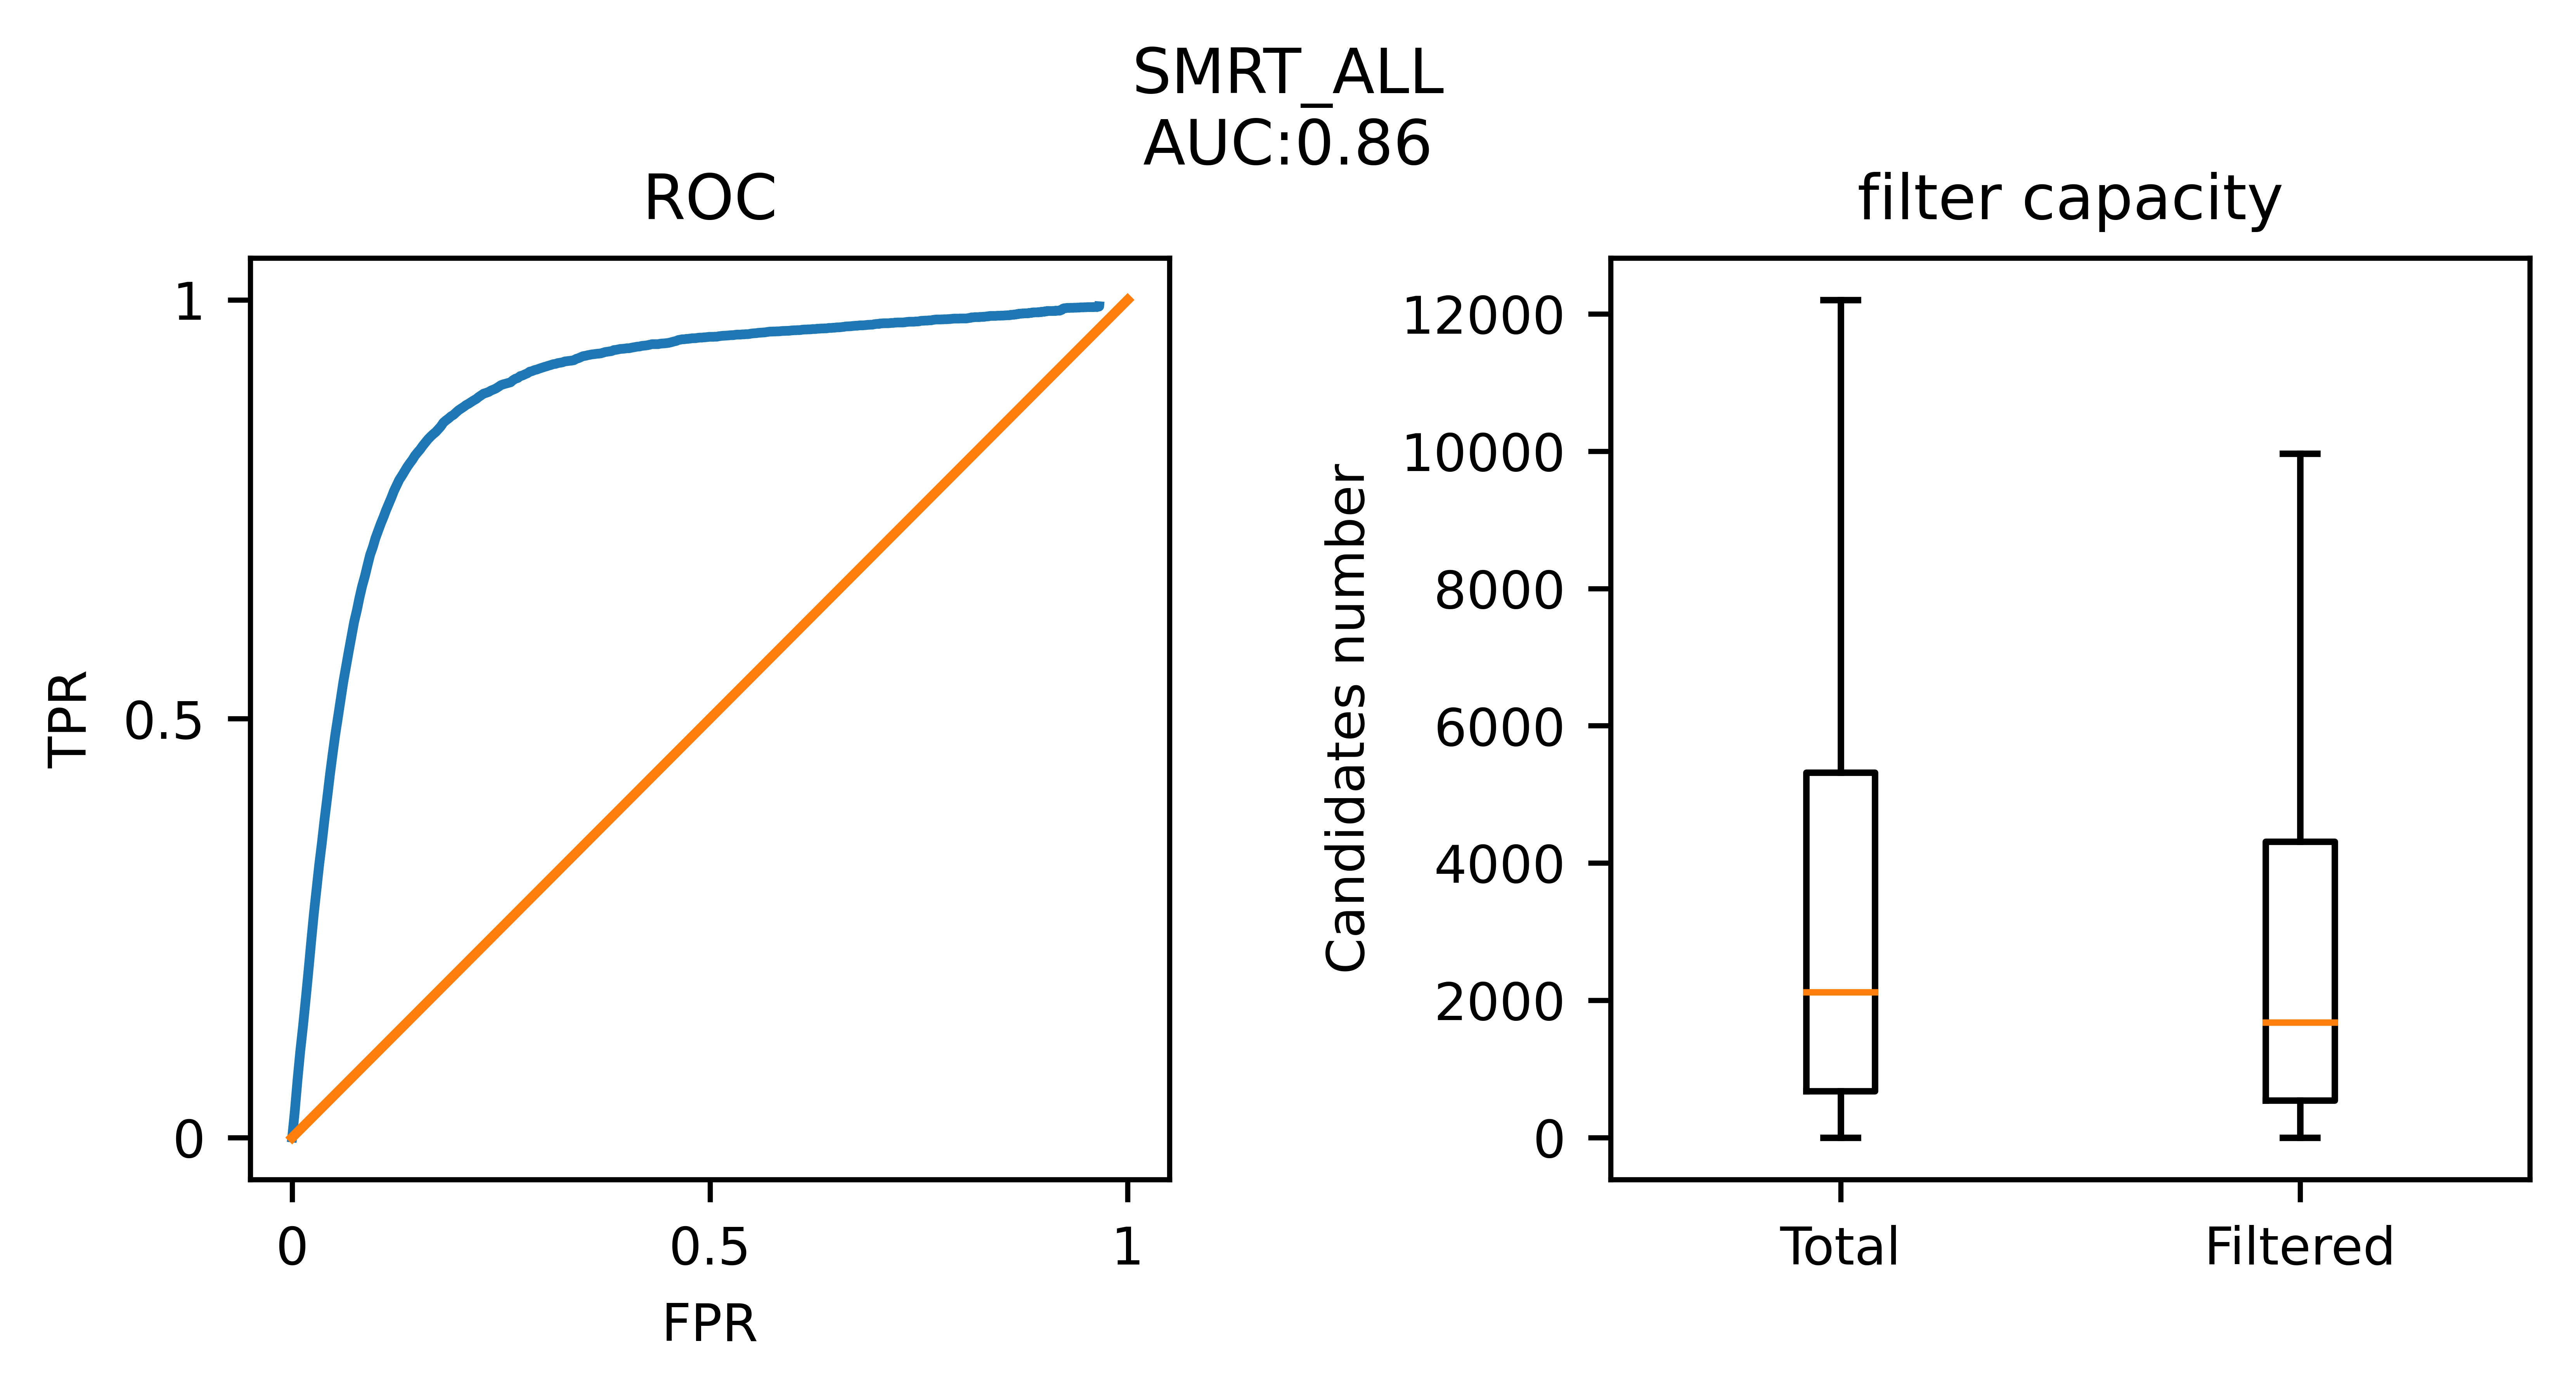

In [16]:
x=[0,1]
y=[0,1]
labels=['Total', 'Filtered']
fig, axs = plt.subplots(1,2, figsize=(6, 3.2), sharey=False, dpi=1200)
i=0
matplotlib.rcParams.update({'font.size': 8})
# for ds in [ds_name]:
    #print(st.mean(RF[ds]))
axs[0].plot(FPR, TPR)
axs[0].plot(x,y)
axs[0].set_yticks([0,0.5, 1])
axs[0].set_xticks([0,0.5, 1])
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_yticklabels(['0', '0.5', '1'])
axs[0].set_xticklabels(['0', '0.5', '1'])
axs[0].set_title('ROC')


axs[1].boxplot((total, filtered), showfliers=False)
axs[1].set_xticklabels(labels, fontsize=8)
axs[1].set_ylabel('Candidates number')
fig.tight_layout(pad=3.0)
axs[1].set_title('filter capacity')
fig.suptitle(f'SMRT_ALL\nAUC:{AUC:.2f}')
plt.savefig(f'./figs/all_ROC_AUC={AUC:.2f}_threshold={thresh}.svg',)

In [11]:
all = np.array(total)
f = np.array(filtered)


inf


C:\Users\XueJun\AppData\Local\Temp\ipykernel_99968\2178490262.py:3: RuntimeWarning: divide by zero encountered in divide
  print((all/f).mean())


In [12]:
(f/all).mean()

0.808952624530949

In [13]:
np.save('./all_total.npy',all)
np.save('./all_filtered.npy',f)

In [14]:
np.save('./all_TPR.npy',TPR)
np.save('./all_FPR.npy',FPR)

In [18]:
np.save('./all_thresh.npy',thresh)
np.save('./all_AUC.npy',AUC)